#  Custom model

Cuando utilizar emplear un custom model
* Tenemos un problema que involucra más de un problema elemental (ie. Imágenes con datos tabulados)
* El problema no es básico.
* Necesitamos un control particular sobre el modelo, como el framework (TensorFlow, PyTorch, Scikit-Learn)
* El equipo que se encarga del modelo no es pequeño.
* El equipo que se encarga del modelo tiene conocimientos.
* Hay tiempo para realizar ajustes y mantenimientos.
* El modelo ha de poder ser mejorado.

# ¿Qué necesitamos?

* Training Package
    * Pre-built (Tensorflow, Scikit-learn, PyTorch)
    * Container o Artifact Registry (Custom Container)
* Model Artifacts
    * Se deben de guardar en un bucket del Storage
* Hyperparameter Tuning
    * Cambiar parametros de entrenamiento, el sistema se encarga de búscar los mejores parametros que den el mejor resultado
* Compute resources
    * Para entrenar el modelo debemos asignar un máquina.
* Endpoint
    * Deploy pre-built (Tensorflow, Scikit-Learn, PyTorch)
    * Deploy Custom

## Prediccion de consumo

Vamos a utilzar un famoso dataset a modo de ejemplo con fines ilustrativos. El dataset esta disponible en UCI Machine Learning Repository.

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

5. Number of Instances: 398

6. Number of Attributes: 9 including the class attribute

7. Attribute Information:

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

8. Missing Attribute Values:  horsepower has 6 missing values

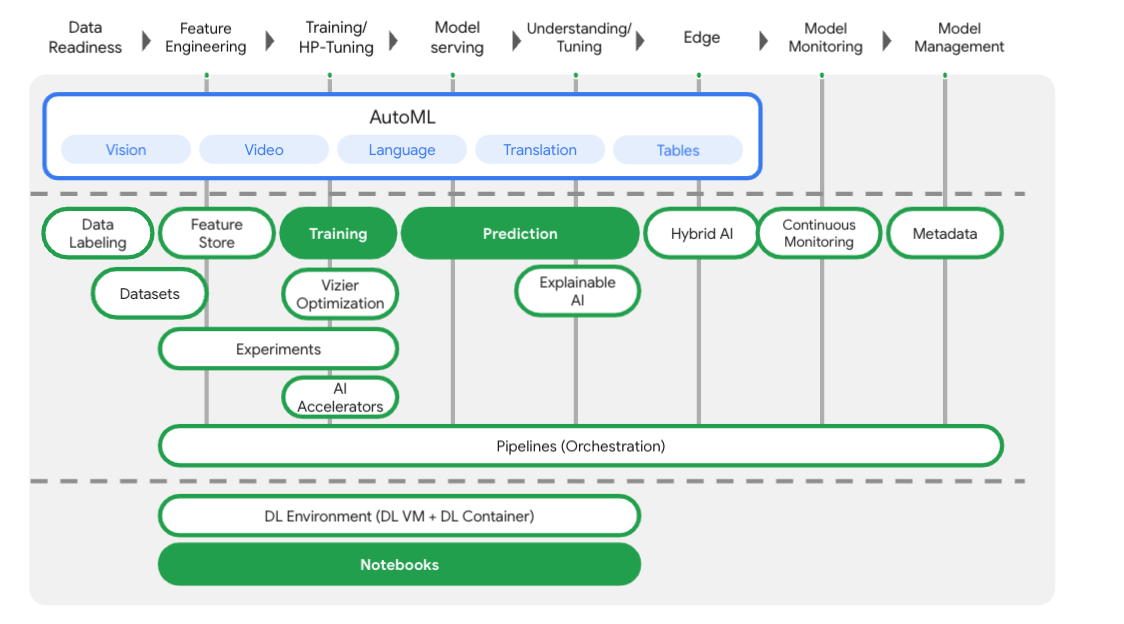

In [2]:
from IPython.display import Image
Image("imagenes/dondeteencuentras.png")

In [8]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
print(f"Pandas version {pd.__version__}")
print(f"seaborn version {sns.__version__}")
print(f"tensorflow version {tf.__version__}")
print(f"sklearn version {skl.__version__}")
print(f"Numpy version {np.__version__}")

Pandas version 1.2.3
seaborn version 0.11.1
tensorflow version 2.4.1
sklearn version 0.24.1
Numpy version 1.19.5


In [10]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [11]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()

In [12]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [14]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


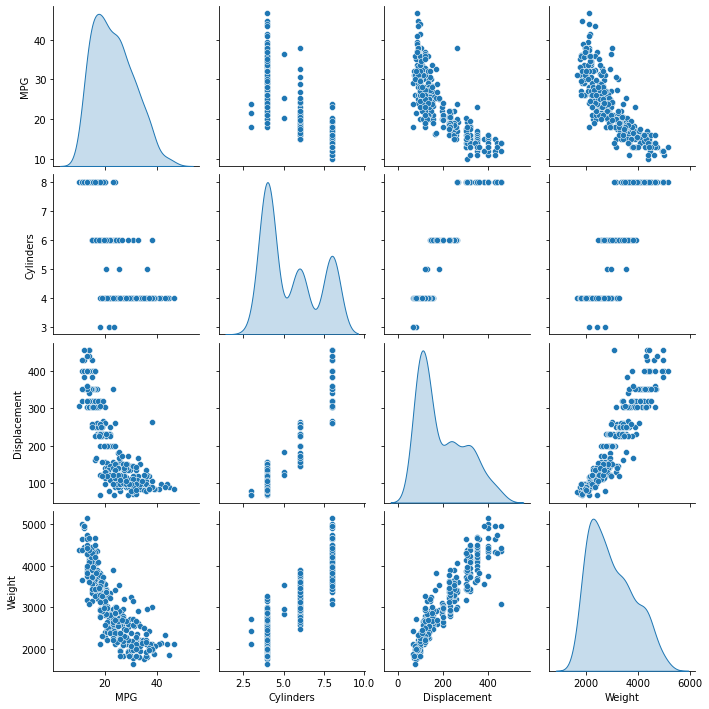

In [15]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [17]:
train_dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [18]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

In [ ]:
model = build_model()

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    callbacks=[early_stop])


# Guardamos el modelo en un bucket, esto es opcional.
BUCKET = 'gs://bucketname'
model.save(BUCKET + '/mimodelo/model')

## Docker

La creación y gestion del docker se ha de ejecutar en bash

In [ ]:
FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3
WORKDIR /root

WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.train"]

Vamos a comprobar que funciona el docker y a subir el container en Google Container Registry, tendremos que comprobar que Google Container Registry API esta funcionando.

In [ ]:
PROJECT_ID=''
IMAGE_URI="gcr.io/$PROJECT_ID/mimodelo:v1"
sudo docker build ./ -t $IMAGE_URI
sudo docker run $IMAGE_URI #Comprobamos que funciona
sudo docker push $IMAGE_URI #Lo subimos a Google Container Registry (Puede ser que de problemas, siguiente celda para resolver)

https://cloud.google.com/container-registry/docs/advanced-authentication

In [ ]:
#En ocasiones podemos encontrar problemas al subir el container, para tratar de resolver los problemas probemos lo siguiente:
sudo -s
gcloud auth configure-docker
gcloud services enable containerregistry.googleapis.com
gcloud auth configure-docker